# Dataset Visualization
Visualize downloaded torchvision datasets (MNIST, CIFAR10)

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## TorchVision MNIST Perturbation Visualization

Loading MNIST + simple_cnn...


LOADING: MNIST + simple_cnn
[1/3] Loading dataset (test split)...
  ✓ Loaded 10000 samples
[2/3] Loading model architecture...
  ✓ Loaded custom model from simple_cnn.py
[3/3] Summary...
  Dataset: 10000 samples (test split)
  Model: 25,710,922 parameters (25,710,922 trainable)
  Batch size: 1
  Preprocessing: Yes

✓ LOADED SUCCESSFULLY

LOADING: MNIST + simple_cnn
[1/3] Loading dataset (test split)...
  ✓ Loaded 10000 samples
[2/3] Loading model architecture...
  ✓ Loaded custom model from simple_cnn.py
[3/3] Summary...
  Dataset: 10000 samples (test split)
  Model: 25,710,922 parameters (25,710,922 trainable)
  Batch size: 1
  Preprocessing: Yes

✓ LOADED SUCCESSFULLY


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8087585].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].


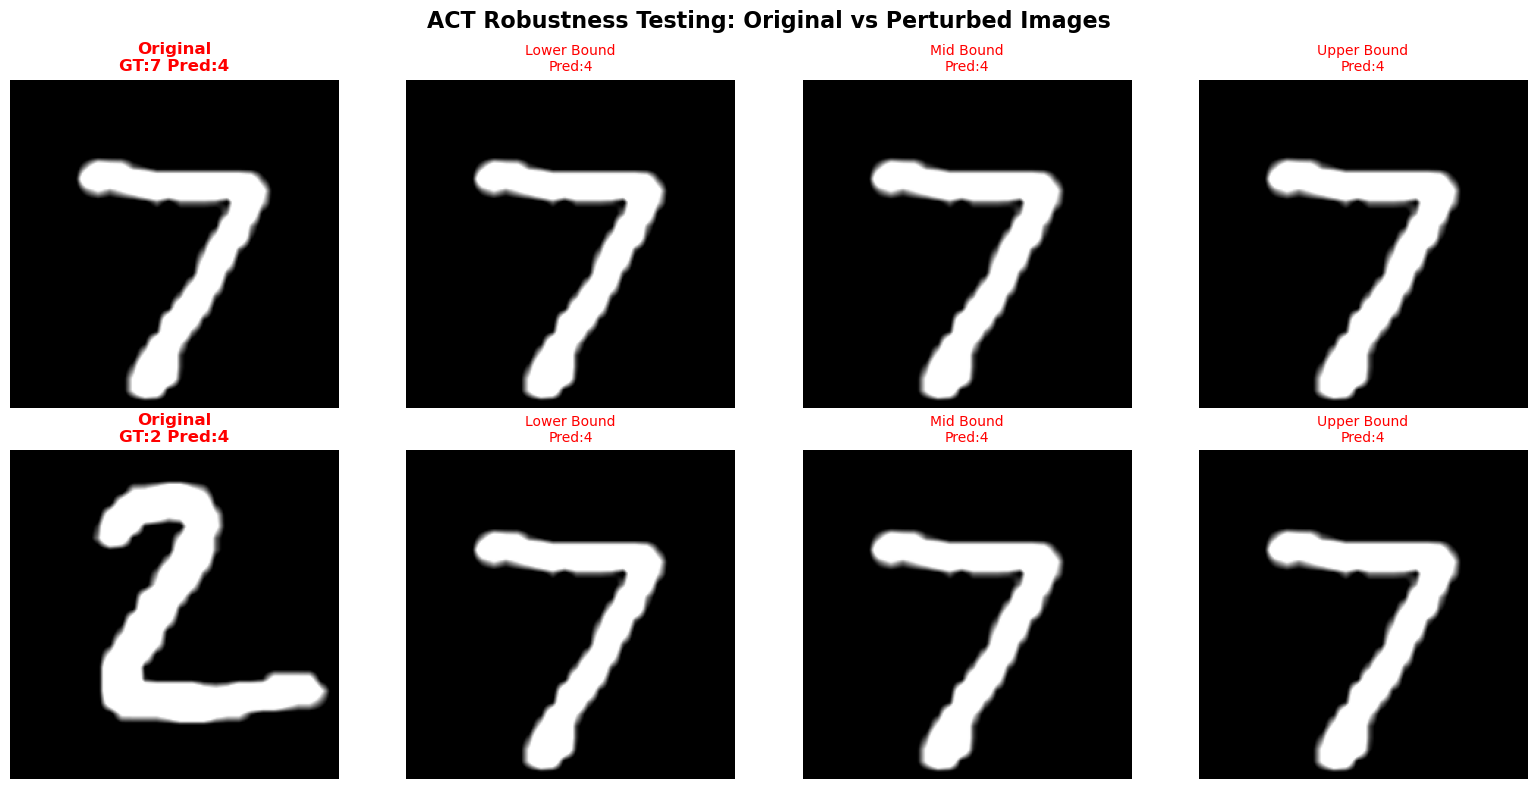


✓ Tested 2 samples with ε=0.05
  Each sample: 1 original + 3 perturbed versions
  Green = Correct prediction | Red = Incorrect prediction
  Spec type: BOX (Box constraints)


In [6]:
# ACT MNIST: Visualize Specs and Test Robustness
import sys
import os

# Setup ACT paths using path_config
act_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
if act_root not in sys.path:
    sys.path.insert(0, act_root)

import torch
import matplotlib.pyplot as plt
import numpy as np
from act.front_end.torchvision_loader.data_model_loader import load_dataset_model_pair
from act.front_end.torchvision_loader.create_specs import TorchVisionSpecCreator
from act.front_end.specs import InKind

# Load MNIST + simple_cnn
print("Loading MNIST + simple_cnn...\n")
pair = load_dataset_model_pair("MNIST", "simple_cnn", split="test", batch_size=1, shuffle=False)
model, dataset = pair['model'], pair['dataset']
model.eval()

# Create spec creator with epsilon=0.05 for visible perturbations
spec_creator = TorchVisionSpecCreator(config_dict={
    'epsilons': [0.05],
    'input_kinds': ['BOX'],
    'output_kinds': ['MARGIN_ROBUST']
})

# Generate specs for 2 samples
results = spec_creator.create_specs_for_data_model_pairs(
    dataset_names=["MNIST"], model_names=["simple_cnn"], 
    num_samples=2, start_index=0, split="test", validate_shapes=False
)

_, _, _, input_tensors, spec_pairs = results[0]

# Visualize: Original + 3 Perturbed versions per image
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('ACT Robustness Testing: Original vs Perturbed Images', fontsize=16, fontweight='bold')

for sample_idx in range(2):
    img_tensor = input_tensors[sample_idx]
    _, label = dataset[sample_idx]
    
    # Original image - handle both grayscale and RGB
    img_np = img_tensor.numpy()
    if img_np.ndim == 3:  # (C, H, W) format
        if img_np.shape[0] == 1:  # Grayscale
            img_display = img_np.squeeze()
            cmap = 'gray'
        else:  # RGB - transpose to (H, W, C)
            img_display = np.transpose(img_np, (1, 2, 0))
            cmap = None
    else:  # Already (H, W)
        img_display = img_np
        cmap = 'gray'
    
    axes[sample_idx, 0].imshow(img_display, cmap=cmap, vmin=0, vmax=1)
    
    with torch.no_grad():
        pred = model(img_tensor.unsqueeze(0)).argmax(dim=1).item()
    color = 'green' if pred == label else 'red'
    axes[sample_idx, 0].set_title(f'Original\nGT:{label} Pred:{pred}', fontweight='bold', color=color)
    axes[sample_idx, 0].axis('off')
    
    # Get spec for this sample
    input_spec = spec_pairs[sample_idx][0]
    lb, ub = input_spec.lb.numpy().squeeze(), input_spec.ub.numpy().squeeze()
    
    # Detect image shape from original tensor
    if img_np.ndim == 3:
        img_shape = img_np.shape  # (C, H, W)
    else:
        img_shape = (1, *img_np.shape)  # (1, H, W)
    
    # Generate 3 perturbed samples: lower bound, center, upper bound
    perturbed_samples = [
        lb,  # Lower bound
        (lb + ub) / 2,  # Mid-point
        ub   # Upper bound
    ]
    
    for pert_idx, pert_img in enumerate(perturbed_samples):
        # Run inference on perturbed image
        pert_tensor = torch.from_numpy(pert_img).float().unsqueeze(0)
        with torch.no_grad():
            pert_pred = model(pert_tensor).argmax(dim=1).item()
        
        # Visualize - reshape to original image shape
        pert_reshaped = pert_img.reshape(img_shape)
        if pert_reshaped.ndim == 3:
            if pert_reshaped.shape[0] == 1:  # Grayscale
                pert_display = pert_reshaped.squeeze()
                pert_cmap = 'gray'
            else:  # RGB
                pert_display = np.transpose(pert_reshaped, (1, 2, 0))
                pert_cmap = None
        else:
            pert_display = pert_reshaped
            pert_cmap = 'gray'
        
        axes[sample_idx, pert_idx + 1].imshow(pert_display, cmap=pert_cmap, vmin=0, vmax=1)
        pert_color = 'green' if pert_pred == label else 'red'
        pert_names = ['Lower', 'Mid', 'Upper']
        axes[sample_idx, pert_idx + 1].set_title(
            f'{pert_names[pert_idx]} Bound\nPred:{pert_pred}',
            color=pert_color, fontsize=10
        )
        axes[sample_idx, pert_idx + 1].axis('off')

plt.tight_layout()
plt.show()

# Summary
eps = spec_creator.config['epsilons'][0]
spec_kind = spec_pairs[0][0].kind
spec_kind_name = spec_kind.name if hasattr(spec_kind, 'name') else str(spec_kind)
print(f"\n✓ Tested {len(input_tensors)} samples with ε={eps}")
print(f"  Each sample: 1 original + 3 perturbed versions")
print(f"  Green = Correct prediction | Red = Incorrect prediction")
print(f"  Spec type: {spec_kind_name} (Box constraints)")


## VNNLib ACASXU Perturbation Visualization

In [8]:
# ACT VNNLib: Visualize ACAS Xu Specs and Test Robustness
import sys
import os

# Setup ACT paths
act_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
if act_root not in sys.path:
    sys.path.insert(0, act_root)

import torch
import matplotlib.pyplot as plt
import numpy as np
from act.front_end.vnnlib_loader.data_model_loader import load_vnnlib_pair
from act.front_end.vnnlib_loader.create_specs import VNNLibSpecCreator

# Load ACAS Xu model and spec
print("Loading ACAS Xu network and specification...\n")
try:
    # Try to load an ACAS Xu example
    vnnlib_pair = load_vnnlib_pair(
        category="acasxu_2023",
        onnx_path="path_to_acasxu.onnx",  # Update with actual path
        vnnlib_path="path_to_spec.vnnlib"  # Update with actual path
    )
    
    model = vnnlib_pair['model']
    input_spec = vnnlib_pair['input_spec']
    output_spec = vnnlib_pair['output_spec']
    
    print(f"✓ Model loaded: {type(model)}")
    print(f"✓ Input spec: {input_spec}")
    print(f"✓ Output spec: {output_spec}")
    
    # ACAS Xu has 5 inputs (normalized relative position/velocity)
    # Visualize the input bounds as a bar chart
    
    input_names = ['ρ (range)', 'θ (angle)', 'ψ (heading)', 'v_own', 'v_int']
    
    if hasattr(input_spec, 'lb') and hasattr(input_spec, 'ub'):
        lb = input_spec.lb.numpy().flatten()
        ub = input_spec.ub.numpy().flatten()
        center = (lb + ub) / 2
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('ACAS Xu Input Specification Visualization', fontsize=16, fontweight='bold')
        
        # Plot 1: Input bounds as bar chart
        x = np.arange(len(input_names))
        width = 0.35
        
        axes[0].bar(x - width/2, lb, width, label='Lower Bound', color='blue', alpha=0.7)
        axes[0].bar(x + width/2, ub, width, label='Upper Bound', color='red', alpha=0.7)
        axes[0].plot(x, center, 'ko-', label='Center', linewidth=2, markersize=8)
        
        axes[0].set_xlabel('Input Variables', fontsize=12)
        axes[0].set_ylabel('Normalized Value', fontsize=12)
        axes[0].set_title('Input Bounds for ACAS Xu Network', fontweight='bold')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(input_names, rotation=45, ha='right')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Input range widths
        ranges = ub - lb
        axes[1].barh(input_names, ranges, color='green', alpha=0.7)
        axes[1].set_xlabel('Range Width (ub - lb)', fontsize=12)
        axes[1].set_title('Input Perturbation Ranges', fontweight='bold')
        axes[1].grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        plt.show()
        
        # Test with 3 sample points: lower bound, center, upper bound
        print("\n" + "="*70)
        print("Testing Network on Sample Points")
        print("="*70)
        
        test_points = {
            'Lower Bound': torch.from_numpy(lb).float().unsqueeze(0),
            'Center': torch.from_numpy(center).float().unsqueeze(0),
            'Upper Bound': torch.from_numpy(ub).float().unsqueeze(0)
        }
        
        model.eval()
        with torch.no_grad():
            for name, point in test_points.items():
                output = model(point)
                action = output.argmax(dim=1).item()
                action_names = ['Clear-of-Conflict', 'Weak Left', 'Weak Right', 
                               'Strong Left', 'Strong Right']
                print(f"\n{name}:")
                print(f"  Input: {point.numpy().flatten()}")
                print(f"  Output: {output.numpy().flatten()}")
                print(f"  Recommended Action: {action_names[action]}")
        
        print("\n" + "="*70)
        print(f"✓ Tested ACAS Xu network on {len(test_points)} sample points")
        print(f"  Input dimension: {len(lb)}")
        print(f"  Output dimension: {output.shape[1]}")
    
except Exception as e:
    print(f"⚠ Could not load ACAS Xu example: {e}")
    print("\nNote: ACAS Xu models require:")
    print("  1. ONNX model file (.onnx)")
    print("  2. VNNLib specification file (.vnnlib)")
    print("  3. Proper paths in data/vnnlib/ directory")
    print("\nFalling back to CIFAR10 visualization...")
    
    # Fallback: Show CIFAR10 as alternative
    cifar_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True,
        transform=transforms.ToTensor()
    )
    
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']
    
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    fig.suptitle('CIFAR10 Dataset - First 10 Images (Fallback)', fontsize=16)
    
    for idx, ax in enumerate(axes.flat):
        img, label = cifar_dataset[idx]
        img = img.numpy().transpose(1, 2, 0)
        ax.imshow(img)
        ax.set_title(f'{class_names[label]}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nCIFAR10 Dataset size: {len(cifar_dataset)}")
    print(f"Image shape: {cifar_dataset[0][0].shape}")

Loading ACAS Xu network and specification...

⚠ Could not load ACAS Xu example: load_vnnlib_pair() got an unexpected keyword argument 'onnx_path'

Note: ACAS Xu models require:
  1. ONNX model file (.onnx)
  2. VNNLib specification file (.vnnlib)
  3. Proper paths in data/vnnlib/ directory

Falling back to CIFAR10 visualization...


  3%|▎         | 4.75M/170M [00:10<06:13, 444kB/s]



KeyboardInterrupt: 

## Visualize with Normalization (as used in verification)

In [ ]:
# MNIST normalization (from your configs)
mnist_mean = 0.1307
mnist_std = 0.3081

mnist_img, mnist_label = mnist_dataset[0]
mnist_normalized = (mnist_img - mnist_mean) / mnist_std

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(mnist_img.squeeze(), cmap='gray')
axes[0].set_title(f'Original MNIST\nRange: [{mnist_img.min():.3f}, {mnist_img.max():.3f}]')
axes[0].axis('off')

axes[1].imshow(mnist_normalized.squeeze(), cmap='gray')
axes[1].set_title(f'Normalized MNIST\nRange: [{mnist_normalized.min():.3f}, {mnist_normalized.max():.3f}]')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Creating Verification Bounds for Torchvision Images

For verification, you need to define perturbation bounds around the original image.

In [ ]:
"""
Common approaches to create verification bounds for images:

1. L_infinity (L∞) perturbation: Each pixel can vary by ±ε
2. L2 perturbation: Total L2 distance from center ≤ ε
3. Box constraints: Manual per-pixel bounds
4. Normalized bounds: Apply after normalization (mean/std)
"""

def create_linf_bounds(image, epsilon, pixel_range=(0, 1)):
    """
    Create L_infinity perturbation bounds around an image.
    
    Args:
        image: torch.Tensor or numpy array (H, W) or (C, H, W)
        epsilon: Maximum perturbation per pixel
        pixel_range: Valid pixel value range (min, max)
    
    Returns:
        lower_bounds, upper_bounds (numpy arrays, flattened)
    """
    if isinstance(image, torch.Tensor):
        image = image.numpy()
    
    center = image.flatten()
    lower = np.clip(center - epsilon, pixel_range[0], pixel_range[1])
    upper = np.clip(center + epsilon, pixel_range[0], pixel_range[1])
    
    return lower, upper


def create_normalized_linf_bounds(image, epsilon, mean, std, pixel_range=(0, 1)):
    """
    Create L_infinity bounds in the normalized space (after mean/std normalization).
    
    This is what's typically used in neural network verification:
    1. Image pixels are in [0, 1]
    2. Add ±ε perturbation
    3. Then normalize: (x - mean) / std
    
    Args:
        image: Original image in [0, 1] range
        epsilon: Perturbation in original pixel space
        mean: Normalization mean
        std: Normalization std
        pixel_range: Valid pixel range before normalization
    
    Returns:
        lower_bounds, upper_bounds in normalized space
    """
    if isinstance(image, torch.Tensor):
        image = image.numpy()
    
    center = image.flatten()
    
    # Create bounds in original space
    lower_orig = np.clip(center - epsilon, pixel_range[0], pixel_range[1])
    upper_orig = np.clip(center + epsilon, pixel_range[0], pixel_range[1])
    
    # Normalize both bounds
    lower_normalized = (lower_orig - mean) / std
    upper_normalized = (upper_orig - mean) / std
    
    return lower_normalized, upper_normalized


# Example 1: MNIST with L_infinity perturbation (unnormalized)
print("="*70)
print("Example 1: MNIST L∞ Perturbation (Unnormalized)")
print("="*70)

# *** EXPLICIT LABEL: Torchvision datasets return (image, label) tuples ***
mnist_img, mnist_label = mnist_dataset[5]  # label is explicit and unambiguous!
epsilon_mnist = 0.05

lower_mnist, upper_mnist = create_linf_bounds(mnist_img.squeeze(), epsilon_mnist)

print(f"✓ Dataset returns: (image, label) tuple")
print(f"✓ Image: MNIST test sample 5")
print(f"✓ Ground Truth Label: {mnist_label} (explicit integer)")
print(f"✓ Epsilon (L∞): {epsilon_mnist}")
print(f"  Original image range: [{mnist_img.min():.3f}, {mnist_img.max():.3f}]")
print(f"  Lower bounds range: [{lower_mnist.min():.3f}, {lower_mnist.max():.3f}]")
print(f"  Upper bounds range: [{upper_mnist.min():.3f}, {upper_mnist.max():.3f}]")
print(f"  Input dimension: {len(lower_mnist)}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(mnist_img.squeeze(), cmap='gray', vmin=0, vmax=1)
axes[0].set_title(f'Original Image\n★ Ground Truth Label: {mnist_label} ★', fontweight='bold')
axes[0].axis('off')

axes[1].imshow(lower_mnist.reshape(28, 28), cmap='gray', vmin=0, vmax=1)
axes[1].set_title(f'Lower Bound\n(image - {epsilon_mnist})')
axes[1].axis('off')

axes[2].imshow(upper_mnist.reshape(28, 28), cmap='gray', vmin=0, vmax=1)
axes[2].set_title(f'Upper Bound\n(image + {epsilon_mnist})')
axes[2].axis('off')

plt.tight_layout()
plt.show()


# Example 2: MNIST with normalized bounds (as used in verification)
print("\n" + "="*70)
print("Example 2: MNIST L∞ Perturbation (Normalized Space)")
print("="*70)

mnist_mean = 0.1307
mnist_std = 0.3081
epsilon_norm = 0.03

lower_norm, upper_norm = create_normalized_linf_bounds(
    mnist_img.squeeze(), epsilon_norm, mnist_mean, mnist_std
)

print(f"✓ Ground Truth Label: {mnist_label} (from torchvision dataset)")
print(f"  Epsilon (L∞) in original space: {epsilon_norm}")
print(f"  Mean: {mnist_mean}, Std: {mnist_std}")
print(f"  Normalized lower bounds range: [{lower_norm.min():.3f}, {lower_norm.max():.3f}]")
print(f"  Normalized upper bounds range: [{upper_norm.min():.3f}, {upper_norm.max():.3f}]")

# Visualize normalized bounds
center_norm = (mnist_img.numpy().flatten() - mnist_mean) / mnist_std
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(center_norm.reshape(28, 28), cmap='gray')
axes[0].set_title(f'Normalized Center\n★ Label: {mnist_label} ★', fontweight='bold')
axes[0].axis('off')

axes[1].imshow(lower_norm.reshape(28, 28), cmap='gray')
axes[1].set_title(f'Lower Bound (Normalized)')
axes[1].axis('off')

axes[2].imshow(upper_norm.reshape(28, 28), cmap='gray')
axes[2].set_title(f'Upper Bound (Normalized)')
axes[2].axis('off')

plt.tight_layout()
plt.show()


# Example 3: CIFAR10 with L_infinity perturbation
print("\n" + "="*70)
print("Example 3: CIFAR10 L∞ Perturbation")
print("="*70)

# *** EXPLICIT LABEL: Again, (image, label) tuple ***
cifar_img, cifar_label = cifar_dataset[0]  # label is explicit!
epsilon_cifar = 0.02  # 2/255 ≈ 0.0078 is common for CIFAR10

lower_cifar, upper_cifar = create_linf_bounds(cifar_img, epsilon_cifar)

print(f"✓ Dataset returns: (image, label) tuple")
print(f"✓ Image: CIFAR10 test sample 0")
print(f"✓ Ground Truth Label: {cifar_label} ({class_names[cifar_label]})")
print(f"  Epsilon (L∞): {epsilon_cifar} (equivalent to {epsilon_cifar*255:.1f}/255)")
print(f"  Image shape: {cifar_img.shape} -> flattened to {len(lower_cifar)}")
print(f"  Original image range: [{cifar_img.min():.3f}, {cifar_img.max():.3f}]")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(cifar_img.numpy().transpose(1, 2, 0))
axes[0].set_title(f'Original Image\n★ Label: {cifar_label} ({class_names[cifar_label]}) ★', fontweight='bold')
axes[0].axis('off')

axes[1].imshow(lower_cifar.reshape(3, 32, 32).transpose(1, 2, 0))
axes[1].set_title(f'Lower Bound\n(image - {epsilon_cifar})')
axes[1].axis('off')

axes[2].imshow(upper_cifar.reshape(3, 32, 32).transpose(1, 2, 0))
axes[2].set_title(f'Upper Bound\n(image + {epsilon_cifar})')
axes[2].axis('off')

plt.tight_layout()
plt.show()


# Summary
print("\n" + "="*70)
print("Summary: How to Get Verification Bounds with Labels")
print("="*70)
print("""
For torchvision images:

✓ **LABELS ARE EXPLICIT**: Each dataset item is a (image, label) tuple
  - mnist_img, mnist_label = mnist_dataset[0]
  - The label is an integer (0-9 for MNIST/CIFAR10, 0-99 for CIFAR100)
  - No ambiguity, no parsing needed!

✓ **BOUNDS ARE USER-DEFINED**: You create them based on verification goals
  - L∞ ball with ε = 0.01 to 0.1 (common: 0.03 for MNIST, 2/255 for CIFAR10)
  - Apply before or after normalization (depends on network)
  - Always clip to valid pixel range [0, 1]

✓ **VERIFICATION PROPERTY**: Combine bounds + label for verification
  - Input spec: All images in epsilon-ball around original image
  - Output property: Model should predict the ground truth label
  - Example: "For all images within ε=0.03, model predicts digit 5"

CONTRAST WITH VNNLIB:
  ✗ VNNLIB: Label is implicit (inferred from property specification)
  ✓ Torchvision: Label is explicit (directly accessible as integer)
  
This is why torchvision is easier for creating custom verification tasks!
""")


## Visualize Image from VNNLIB File

VNNLIB files contain numerical constraints on input pixels. We can extract these to reconstruct the image.

In [ ]:
# Parse a VNNLIB file and extract image bounds
def parse_vnnlib_bounds(vnnlib_path):
    """
    Parse VNNLIB file and extract lower/upper bounds for each input variable.
    Returns: (lower_bounds, upper_bounds) as numpy arrays
    """
    import re
    
    bounds = {}
    
    with open(vnnlib_path, 'r') as f:
        content = f.read()
    
    # Extract variable declarations to get input dimension
    # Pattern: (declare-const X_i Real)
    var_pattern = r'X_(\d+)'
    var_indices = set()
    for match in re.finditer(var_pattern, content):
        var_indices.add(int(match.group(1)))
    
    n_vars = len(var_indices)
    if n_vars == 0:
        print("No input variables found in VNNLIB file")
        return None, None
    
    # Initialize bounds
    lower_bounds = np.full(n_vars, -np.inf)
    upper_bounds = np.full(n_vars, np.inf)
    
    # Parse assertions: (assert (>= X_i value)) or (assert (<= X_i value))
    # Lower bound: X_i >= value
    lower_pattern = r'\(assert\s+\(>=\s+X_(\d+)\s+([-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?)\)\)'
    for match in re.finditer(lower_pattern, content):
        idx = int(match.group(1))
        value = float(match.group(2))
        lower_bounds[idx] = max(lower_bounds[idx], value)
    
    # Upper bound: X_i <= value
    upper_pattern = r'\(assert\s+\(<=\s+X_(\d+)\s+([-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?)\)\)'
    for match in re.finditer(upper_pattern, content):
        idx = int(match.group(1))
        value = float(match.group(2))
        upper_bounds[idx] = min(upper_bounds[idx], value)
    
    return lower_bounds, upper_bounds


# Create a simple example VNNLIB with concrete values for demonstration
print("Note: The VNNLIB files in data/vnnlib/ use symbolic constraints (X_hat_i, eps)")
print("which can't be parsed without concrete values.")
print("\nCreating a simple MNIST example with concrete values...\n")

# Generate a sample MNIST image region (center point with epsilon perturbation)
# Let's use the first MNIST test image as reference
mnist_img_example, _ = mnist_dataset[0]
mnist_flat = mnist_img_example.numpy().flatten()  # 784 values

# Create bounds: [center - 0.03, center + 0.03]
epsilon = 0.03
center = mnist_flat
lower = np.clip(center - epsilon, 0, 1)  # Clip to valid pixel range
upper = np.clip(center + epsilon, 0, 1)

print(f"Input dimension: {len(center)}")
print(f"Epsilon: {epsilon}")
print(f"Value range: [{lower.min():.3f}, {upper.max():.3f}]")
print(f"Center point range: [{center.min():.3f}, {center.max():.3f}]")

# Visualize the region
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image (center)
img_center = center.reshape(28, 28)
axes[0].imshow(img_center, cmap='gray', vmin=0, vmax=1)
axes[0].set_title(f'Center Image\n(original MNIST test image 0)')
axes[0].axis('off')

# Lower bound
img_lower = lower.reshape(28, 28)
axes[1].imshow(img_lower, cmap='gray', vmin=0, vmax=1)
axes[1].set_title(f'Lower Bound\n(center - {epsilon})')
axes[1].axis('off')

# Upper bound
img_upper = upper.reshape(28, 28)
axes[2].imshow(img_upper, cmap='gray', vmin=0, vmax=1)
axes[2].set_title(f'Upper Bound\n(center + {epsilon})')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\nThis shows the input region that would be verified:")
print(f"All images where each pixel is within ±{epsilon} of the center image.")
print(f"Total verification region contains infinitely many images in this hyperrectangle.")

## VNNLIB Benchmarks vs. Torchvision + Custom Perturbations

Comparison of two approaches for neural network verification.

In [ ]:
"""
COMPARISON: VNNLIB Benchmarks vs. Torchvision + Custom Perturbations

Both approaches are valid for verification, but serve different purposes.
"""

comparison_table = """
╔═══════════════════════════════════════════════════════════════════════════════╗
║                    VNNLIB BENCHMARKS (e.g., VNN-COMP)                         ║
╠═══════════════════════════════════════════════════════════════════════════════╣
║ BENEFITS:                                                                     ║
║ ✓ Standardized benchmarks - everyone uses the same tasks                     ║
║ ✓ Fair comparison - reproducible results across tools                        ║
║ ✓ Pre-vetted properties - carefully designed verification tasks              ║
║ ✓ Community acceptance - published papers reference these                    ║
║ ✓ Diverse tasks - multiple domains (MNIST, CIFAR, ACAS Xu, etc.)            ║
║ ✓ Difficulty levels - from easy to extremely challenging                     ║
║ ✓ Ready to use - no need to design specifications                            ║
║                                                                               ║
║ USE CASES:                                                                    ║
║ • Publishing research papers (need standard benchmarks)                      ║
║ • Comparing verification tools (fair evaluation)                             ║
║ • Competition participation (VNN-COMP)                                        ║
║ • Validating new verification techniques                                     ║
║ • Testing tool scalability on known-difficulty problems                      ║
║                                                                               ║
║ DRAWBACKS:                                                                    ║
║ ✗ Fixed specifications - can't customize for your needs                      ║
║ ✗ Limited to benchmark datasets - may not match your domain                  ║
║ ✗ Complex format - VNNLIB parsing can be tricky                             ║
║ ✗ Large files - some benchmarks are very resource-intensive                 ║
║ ✗ May not reflect real-world verification tasks                              ║
╚═══════════════════════════════════════════════════════════════════════════════╝

╔═══════════════════════════════════════════════════════════════════════════════╗
║              TORCHVISION + CUSTOM PERTURBATIONS (DIY Approach)                ║
╠═══════════════════════════════════════════════════════════════════════════════╣
║ BENEFITS:                                                                     ║
║ ✓ Full flexibility - choose any image, any epsilon, any property             ║
║ ✓ Easy to understand - simple numpy operations                               ║
║ ✓ Quick prototyping - test ideas rapidly                                     ║
║ ✓ Custom domains - use your own datasets and models                          ║
║ ✓ Fine-grained control - adjust every parameter                              ║
║ ✓ Lightweight - no large benchmark downloads needed                          ║
║ ✓ Educational - great for learning verification concepts                     ║
║                                                                               ║
║ USE CASES:                                                                    ║
║ • Developing new verification tools (rapid iteration)                        ║
║ • Research exploration (trying new ideas)                                    ║
║ • Custom applications (specific industry needs)                              ║
║ • Learning verification (understanding basics)                               ║
║ • Debugging verification issues (controlled experiments)                     ║
║ • Creating your own benchmarks (new research directions)                     ║
║                                                                               ║
║ DRAWBACKS:                                                                    ║
║ ✗ No standardization - hard to compare with other work                       ║
║ ✗ Manual specification - need to define properties yourself                  ║
║ ✗ Less credibility - reviewers may question novelty                          ║
║ ✗ Potential for trivial cases - might miss edge cases                        ║
║ ✗ No community baselines - can't reference existing results                  ║
╚═══════════════════════════════════════════════════════════════════════════════╝
"""

print(comparison_table)

print("\n" + "="*80)
print("DETAILED COMPARISON")
print("="*80)

aspects = {
    "🎯 Purpose": {
        "VNNLIB": "Competition, benchmarking, publication",
        "Custom": "Development, exploration, custom applications"
    },
    "📊 Reproducibility": {
        "VNNLIB": "Perfect - everyone gets same results",
        "Custom": "Variable - depends on your documentation"
    },
    "⚙️ Complexity": {
        "VNNLIB": "High - need VNNLIB parser, handle edge cases",
        "Custom": "Low - just numpy/torch operations"
    },
    "🔧 Flexibility": {
        "VNNLIB": "None - fixed specifications",
        "Custom": "Complete - full control over everything"
    },
    "📚 Documentation": {
        "VNNLIB": "Extensive - papers, competition reports",
        "Custom": "You write it - need clear methodology"
    },
    "🚀 Setup Time": {
        "VNNLIB": "Medium - download benchmarks, set up parser",
        "Custom": "Fast - pip install torchvision, done"
    },
    "💻 Resource Usage": {
        "VNNLIB": "High - some benchmarks are huge (GB of data)",
        "Custom": "Low - only load what you need"
    },
    "🎓 Learning Curve": {
        "VNNLIB": "Steep - SMT-LIB syntax, ONNX models",
        "Custom": "Gentle - familiar PyTorch operations"
    },
    "🏆 Credibility": {
        "VNNLIB": "High - established benchmarks",
        "Custom": "Variable - depends on rigor"
    },
    "🔍 Debugging": {
        "VNNLIB": "Hard - complex specifications, black box",
        "Custom": "Easy - you control everything"
    }
}

for aspect, comparison in aspects.items():
    print(f"\n{aspect}")
    print(f"  VNNLIB:  {comparison['VNNLIB']}")
    print(f"  Custom:  {comparison['Custom']}")

print("\n" + "="*80)
print("RECOMMENDATION: Which to Use?")
print("="*80)

recommendations = """
🎓 **FOR LEARNING & EDUCATION:**
   → Start with Torchvision + Custom Perturbations
   - Understand verification concepts first
   - Build intuition with simple examples
   - Experiment freely without constraints

🔬 **FOR RESEARCH & DEVELOPMENT:**
   → Use BOTH approaches
   - Custom for rapid prototyping and exploration
   - VNNLIB for final validation and comparison
   - Custom for ablation studies, VNNLIB for main results

📝 **FOR PUBLICATION:**
   → Prioritize VNNLIB Benchmarks
   - Include VNN-COMP or established benchmarks
   - Can supplement with custom experiments
   - Reviewers expect standard benchmarks

🏭 **FOR INDUSTRY APPLICATIONS:**
   → Torchvision + Custom Perturbations
   - Your data, your models, your requirements
   - Need flexibility for specific use cases
   - May create internal benchmarks

🏆 **FOR COMPETITIONS:**
   → Must use VNNLIB (competition requirement)
   - VNN-COMP provides all benchmarks
   - No choice here - it's the rules

🛠️ **FOR TOOL DEVELOPMENT:**
   → Start Custom, Validate with VNNLIB
   - Custom for testing during development
   - VNNLIB for comprehensive evaluation
   - Both for regression testing
"""

print(recommendations)

print("\n" + "="*80)
print("HYBRID APPROACH (Recommended for ACT Framework)")
print("="*80)

print("""
The ACT framework should support BOTH:

1. **Built-in VNNLIB Support** (for standardization)
   - Full VNNLIB parser (already have in loaders/)
   - VNN-COMP benchmark compatibility
   - Automatic test suite against standard benchmarks

2. **Easy Custom Specification API** (for flexibility)
   - Simple Python functions like `create_linf_bounds()`
   - Direct torchvision dataset integration
   - Quick prototyping for research

3. **Unified Interface**
   - Same verifier backend for both inputs
   - Automatic conversion: custom → internal format ← VNNLIB
   - User chooses input method, verifier doesn't care

EXAMPLE WORKFLOW:
   # Development phase - use custom
   bounds = create_linf_bounds(mnist_img, epsilon=0.03)
   result = verify(model, bounds, property)
   
   # Publication phase - use VNNLIB
   result = verify(model, "vnncomp/mnist_spec.vnnlib")
   
Both should work seamlessly with the same verification backend!
""")